In [10]:
import numpy as np 
import abc
import scipy.stats as si
import matplotlib.pyplot as plt

In [2]:
############################################
# Abstract Class Derivative
############################################

class Derivative(abc.ABC):
    def __init__(self):
        self.name = 'abstract'
        self.params = {}

    @abc.abstractmethod
    def price_monte_carlo(self):
        raise NotImplementedError

    @abc.abstractmethod
    def greeks_difference_method(self):
        raise NotImplementedError
    
    @abc.abstractmethod
    def greeks_exact(self):
        raise NotImplementedError

    @abc.abstractmethod
    def greeks_malliavin(self, x, y, T):
        raise NotImplementedError

In [3]:
############################################
# European Class Derivative
############################################

class EuropeanDerivative(Derivative):
    def __init__(self, S0, K, r, sigma, T, payoff, name):
        self.name = "_".join(['euro',name])
        self.params = {'price_0':S0,'strike':K,'interest_rate':r,'vol':sigma,'maturity':T}
        self.payoff = payoff
    
    def price_monte_carlo(self,N,epsilon = 0,param__=None):
        G = np.random.normal(size=N)
        sum = 0
        params__ = self.params.copy()
        if param__:
            params__[param__] = self.params[param__] + epsilon
        for i in range(N):
            sum += self.payoff(params__['price_0'] * np.exp((params__['interest_rate']-params__['vol']**2/2)*params__['maturity']+params__['vol']*(params__['maturity']**0.5)*G[i]))

        return sum*np.exp(-params__['interest_rate']*params__['maturity'])/N
    

    def greeks_difference_method(self,N,epsilon,param__,order = 1):
        if order == 2 :
            return (self.price_monte_carlo(N,epsilon,param__) + self.price_monte_carlo(N,-epsilon,param__) - 2* self.price_monte_carlo(N))/(epsilon**2)
        if order == 1 : 
            return (self.price_monte_carlo(N,epsilon,param__) - self.price_monte_carlo(N,-epsilon,param__))/(epsilon*2)
    
    def greeks_exact(self):
        raise Exception("No exact formula is available !")

    def __delta__malliavin(self,N):

        G = np.random.normal(size=N)
        sum = 0
        params__ = self.params.copy()
        r,T,S0,sigma = params__['interest_rate'],params__['maturity'],params__['price_0'],params__['vol']

        sum = 0

        for x in G : 
            S_T = S0*np.exp((r-(sigma**2)/2)*T+sigma*(T**0.5)*x)
            sum += self.payoff(S_T)*(x/(sigma*T**0.5))
        
        delta = np.exp(-r*T)*sum/S0
        delta = delta/N

        return delta
    
    def __vega__malliavin(self,N):

        G = np.random.normal(size=N)
        sum = 0
        params__ = self.params.copy()
        r,T,S0,sigma = params__['interest_rate'],params__['maturity'],params__['price_0'],params__['vol']

        sum = 0

        for x in G : 
            S_T = S0*np.exp((r-(sigma**2)/2)*T+sigma*(T**0.5)*x)
            sum += self.payoff(S_T)*((x**2/sigma)-x*(T**0.5)-(1/sigma))
        
        vega = np.exp(-r*T)*sum
        vega = vega/N

        return vega

    
    def __gamma__malliavin(self,N):

        
        T,S0,sigma = self.params['maturity'],self.params['price_0'],self.params['vol']

        return self.__vega__malliavin(N)/(S0*S0*sigma*T)
        
    def greeks_malliavin(self,N, param__,order):
        
        
        if param__ not in ['vol','price_0']:
            raise Exception(f"Invalid param__ {param__} not in ['vol','price_0']")
            return 

        if order not in [1,2]:
            raise Exception(f"Invalid order {order} not in [1,2]")
            return 
        
        if order==1 :
            if param__ == 'vol':
                return self.__vega__malliavin(N)
            
            if param__=='price_0':
                return self.__delta__malliavin(N)

        if order == 2 and param__=='price_0' :
            return self.__gamma__malliavin(N)
        
        raise Exception("Incompatible order and param__")



In [4]:
T = 1
S0 = 100
sigma = 0.20
r = 0.05
K = 75
payoff = lambda x: max(x-K,0)
name = 'call'

In [7]:
call_option = EuropeanDerivative(S0, K, r, sigma, T, payoff, name)

In [50]:
#call_option.greeks_difference_method(N=100_000,epsilon=0.04,param__='vol',order=1)
#call_option.greeks_difference_method(N=100_000,epsilon=8,param__='price_0',order=1)
#call_option.greeks_difference_method(N=100_000,epsilon=8,param__='price_0',order=2)

0.9623180677803431

In [184]:
print(call_option.greeks_malliavin(N=100_000,param__='price_0',order=2))

0.0037754600882600672


In [55]:
class EuropeanCall(EuropeanDerivative):

    def __init__(self, S0, K, r, sigma, T):
        EuropeanDerivative.__init__(self, S0, K, r, sigma, T, lambda x: max(x-K,0) , "call")

    def __black_scholes_params(self):

        r,T,S,sigma, K = self.params['interest_rate'],self.params['maturity'],self.params['price_0'],self.params['vol'], self.params['strike']

        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))

        return d1, d2
    
    def __exact_delta(self):

        d1,d2 = self.__black_scholes_params()
    
        delta = si.norm.cdf(d1, 0.0, 1.0)

        return delta

    def __exact_vega(self):

        d1,d2 = self.__black_scholes_params()
    
        prob_density = 1 / np.sqrt(2 * np.pi) * np.exp(-d1 ** 2 * 0.5)


        
        vega = S0 * prob_density * np.sqrt(self.params['maturity'])

        return vega 

    def __exact_gamma(self):

        d1,d2 = self.__black_scholes_params()


        prob_density = 1 / np.sqrt(2 * np.pi) * np.exp(-d1 ** 2 * 0.5)
        gamma = prob_density / (self.params['price_0'] * self.params['vol'] * np.sqrt(self.params['maturity']))
        
        return gamma
    
    def greeks_exact(self):
        
        delta = self.__exact_delta()
        vega = self.__exact_vega()
        gamma =self.__exact_gamma()

        return delta,vega,gamma

In [56]:
call_option = EuropeanCall(S0, K, r, sigma, T)

In [7]:
N_max = 100

In [14]:
delta, vega, gamma = call_option.greeks_exact()

VEGA_epsilon = [call_option.greeks_difference_method(N=i,epsilon=0.04,param__='vol',order=1) for i in range(N_max)]
DELTA_epsilon = [call_option.greeks_difference_method(N=i,epsilon=8,param__='price_0',order=1)for i in range(N_max)]
GAMMA_epsilon = [call_option.greeks_difference_method(N=i,epsilon=8,param__='price_0',order=2)for i in range(N_max)]

In [15]:
VEGA_malliavin = [call_option.greeks_malliavin(N=i,param__='vol',order=1) for i in range(N_max)]
DELTA_malliavin = [call_option.greeks_malliavin(N=i,param__='price_0',order=1)for i in range(N_max)]
GAMMA_malliavin = [call_option.greeks_malliavin(N=i,param__='price_0',order=2)for i in range(N_max)]

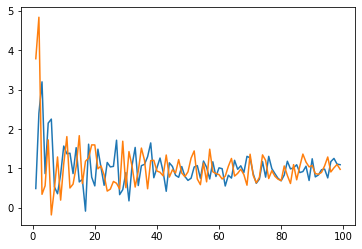

In [17]:
plt.plot(DELTA_epsilon)
plt.plot(DELTA_malliavin)

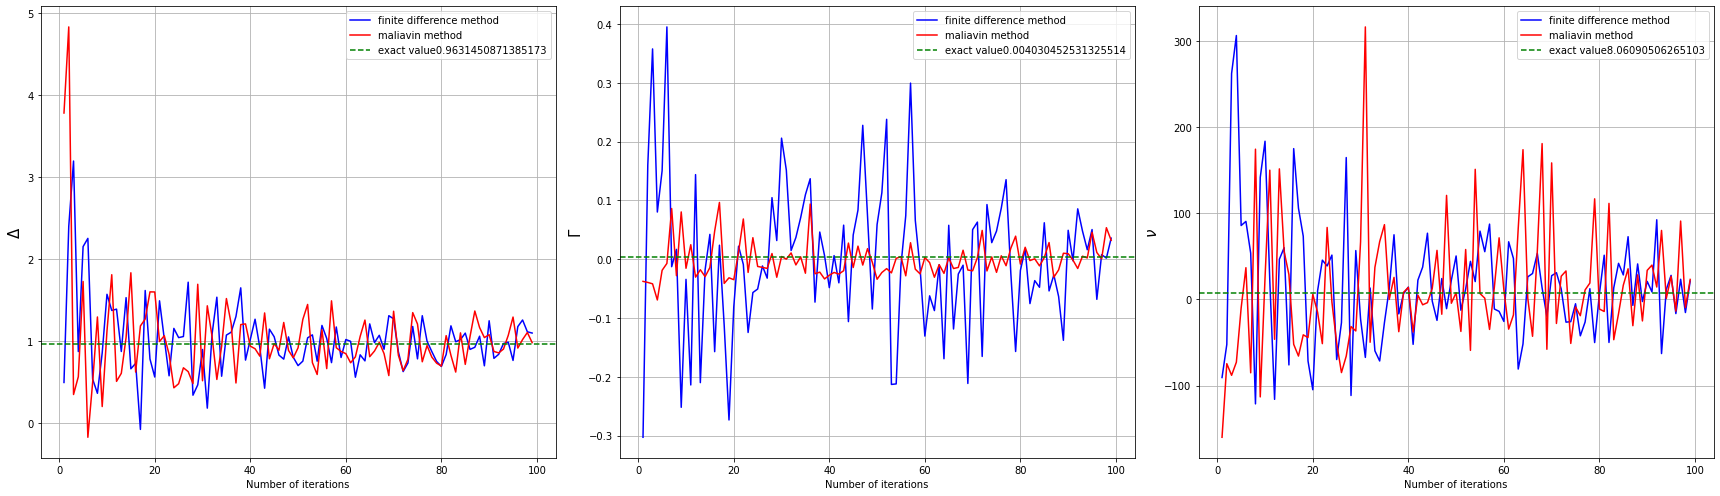

In [53]:
fig, ax =plt.subplots(1,3, sharey=False, figsize=(24,7)) 


ax[0].plot(DELTA_epsilon,label="finite difference method",color="blue")
ax[0].plot(DELTA_malliavin,label="maliavin method",color="red")
ax[0].axhline(y=delta, color='g', linestyle='--',label = f"exact value{delta}")
ax[0].set_xlabel(r"Number of iterations")
ax[0].set_ylabel(r"$\Delta$",fontsize = 15)
ax[0].grid()
ax[0].legend()



ax[1].plot(GAMMA_epsilon,label="finite difference method",color="blue")
ax[1].plot(GAMMA_malliavin,label="maliavin method",color="red")
ax[1].axhline(y=gamma, color='g', linestyle='--',label = f"exact value{gamma}")
ax[1].set_xlabel(r"Number of iterations")
ax[1].set_ylabel(r"$\Gamma$",fontsize = 15)
ax[1].grid()
ax[1].legend()


ax[2].plot(VEGA_epsilon,label="finite difference method",color="blue")
ax[2].plot(VEGA_malliavin,label="maliavin method",color="red")
ax[2].axhline(y=vega, color='g', linestyle='--',label = f"exact value{vega}")
ax[2].set_xlabel(r"Number of iterations")
ax[2].set_ylabel(r"$\nu$",fontsize = 15)
ax[2].grid()
ax[2].legend()


plt.legend()
plt.tight_layout()
plt.show()